In [1]:
import os
# Set cuda device to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# do not prealocate memory
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

import jax
jax.config.update('jax_default_device', 'cpu')
# jax.config.update("jax_enable_x64", True)
jax.config.update('jax_default_matmul_precision', 'highest')

# Testing Dynamic Factor Analysis (DFA)

In [2]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import equinox as eqx


from jax import block_until_ready, vmap

from sppcax.models import BayesianDynamicFactorAnalysis as BDFA
from dynamax.linear_gaussian_ssm import parallel_lgssm_smoother, lgssm_smoother
from sppcax.inference.smoothing import lgssm_smoother as sppcax_smoother

import matplotlib.pyplot as plt
import seaborn as sns

## 1. Generate Synthetic Data

Generated z_true shape: (500, 2)
Generated y_obs shape: (500, 10)


<Axes: >

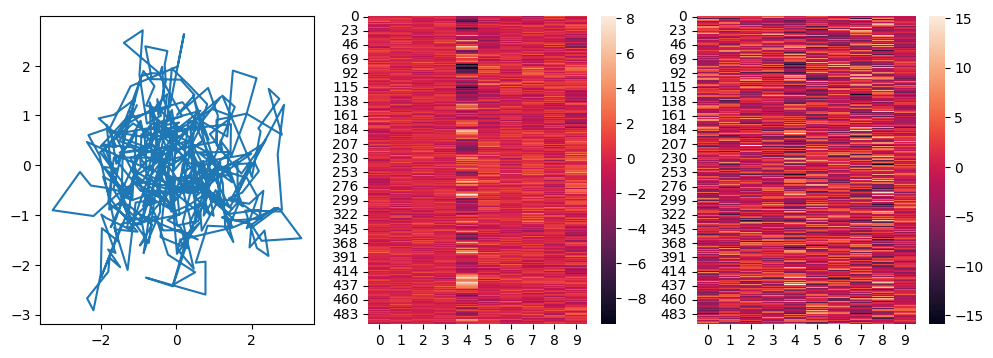

In [3]:
key = jr.PRNGKey(42)
n_components = 2  # Latent dimension (k)
n_features = 10   # Observation dimension (d)
n_timesteps = 500  # Time steps (T)

# True parameters
A_true = jnp.array([[0.9, 0.0], [0, 0.85]])

key, subkey = jr.split(key)
Q_true_diag = jr.uniform(subkey, (n_components,), minval=0.1, maxval=0.3)
Q_true = jnp.diag(Q_true_diag)

key, subkey1, subkey2 = jr.split(key, 3)
C_true = jr.normal(subkey1, (n_features, n_components)) * jr.bernoulli(subkey2, p=0.2, shape=(n_features, n_components))
sorted_idx = jnp.argsort(jnp.isclose(C_true, 0.0).sum(0))
C_true = C_true[:, sorted_idx]

key, subkey = jr.split(key)
R_true_diag = jr.uniform(subkey, (n_features,), minval=0.5, maxval=1.0)
R_true = jnp.diag(R_true_diag)

z0_true = jnp.zeros(n_components)
Sigma0_true = jnp.eye(n_components)

# Generate latent states (z) and observations (y)
z_true = jnp.zeros((n_timesteps, n_components))
y_obs = jnp.zeros((n_timesteps, n_features))

key, subkey1, subkey2 = jr.split(key, 3)
z_curr = jr.multivariate_normal(subkey1, z0_true, Sigma0_true)
z_true = z_true.at[0].set(z_curr)
y_obs = y_obs.at[0].set(jr.multivariate_normal(subkey2, C_true @ z_curr, R_true))

for t in range(1, n_timesteps):
    key, subkey1, subkey2 = jr.split(key, 3)
    z_curr = jr.multivariate_normal(subkey1, A_true @ z_curr, Q_true)
    z_true = z_true.at[t].set(z_curr)
    y_obs = y_obs.at[t].set(jr.multivariate_normal(subkey2, C_true @ z_curr, R_true))

n_input = 20
key, _key = jr.split(key)
U = jr.normal(_key, shape=(n_timesteps, n_input))

key, _key = jr.split(key)
B = jr.multivariate_normal(_key, jnp.zeros(n_features), R_true, shape=(n_input)).mT
y_obs_with_u = y_obs + U @ B.mT

print(f"Generated z_true shape: {z_true.shape}")
print(f"Generated y_obs shape: {y_obs.shape}")

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].plot(z_true[:, 0], z_true[:, 1])
sns.heatmap(y_obs, ax=axes[1])
sns.heatmap(y_obs_with_u, ax=axes[2])

## 2. Initialize DFA Model

In [4]:
key, model_key = jr.split(key)
dfa_model = BDFA(n_components, n_features)

init_params, props = dfa_model.initialize(
    model_key,
    dynamics_weights=A_true,
    dynamics_covariance=Q_true,
    emission_weights=C_true,
    emission_covariance=R_true
)

%timeit block_until_ready(lgssm_smoother(init_params, y_obs))
%timeit block_until_ready(parallel_lgssm_smoother(init_params, y_obs))

eqx.filter_jit(parallel_lgssm_smoother)(init_params, y_obs)
eqx.filter_jit(lgssm_smoother)(init_params, y_obs)
%timeit block_until_ready(eqx.filter_jit(lgssm_smoother)(init_params, y_obs))
%timeit block_until_ready(eqx.filter_jit(parallel_lgssm_smoother)(init_params, y_obs))

188 ms ± 5.16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
235 ms ± 6.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
5.97 ms ± 126 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.75 ms ± 601 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## 3. Test latent state inference

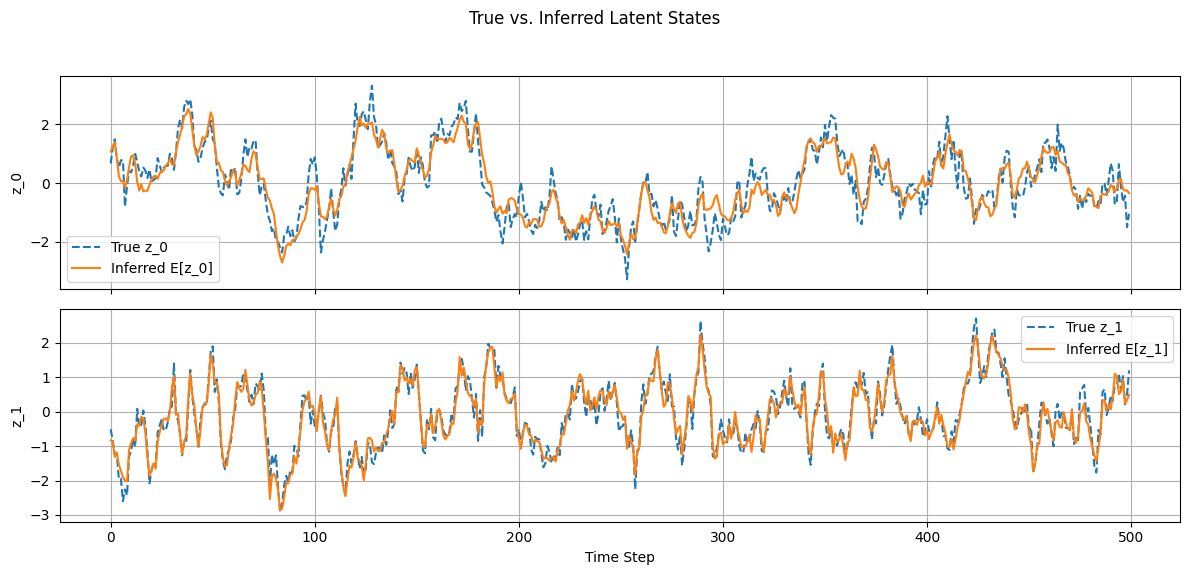

-6901.8359375


In [5]:
# Run E-step
post = parallel_lgssm_smoother(init_params, y_obs)
Ez_smooth = post.smoothed_means

# Plot true vs inferred states (if n_components is small)
if n_components <= 3:
    fig, axes = plt.subplots(n_components, 1, figsize=(12, 3 * n_components), sharex=True)
    if n_components == 1:
        axes = [axes] # Make iterable
    time = jnp.arange(n_timesteps)
    for i in range(n_components):
        axes[i].plot(time, z_true[:, i], label=f'True z_{i}', linestyle='--')
        axes[i].plot(time, Ez_smooth[:, i], label=f'Inferred E[z_{i}]')
        axes[i].set_ylabel(f'z_{i}')
        axes[i].legend()
        axes[i].grid(True)
    axes[-1].set_xlabel('Time Step')
    fig.suptitle('True vs. Inferred Latent States')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

print(post.marginal_loglik.item())

## 4. Test M-step and VBM-step

In [6]:
from functools import partial
from dynamax.utils.utils import ensure_array_has_batch_dim

batch_stats, _ = vmap(partial(dfa_model.e_step, init_params))(y_obs[None], None)

%timeit block_until_ready(vmap(partial(dfa_model.e_step, init_params))(y_obs[None], None))
%timeit block_until_ready(dfa_model.m_step(init_params, props, batch_stats, None))

231 ms ± 7.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
14.4 ms ± 507 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
init_params, props = dfa_model.initialize(
    model_key,
    dynamics_weights=A_true,
    dynamics_covariance=Q_true,
    emission_weights=C_true,
    emission_covariance=R_true,
    variational_bayes=True
)

In [8]:
batch_stats, _ = vmap(partial(dfa_model.vbe_step, init_params))(y_obs[None], None)

%timeit block_until_ready(vmap(partial(dfa_model.vbe_step, init_params))(y_obs[None], None))
%timeit block_until_ready(eqx.filter_jit(dfa_model.vbm_step)(init_params, props, batch_stats, None))

374 ms ± 8.87 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
734 μs ± 109 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


# 5. Test the full EM/VBEM algorithm

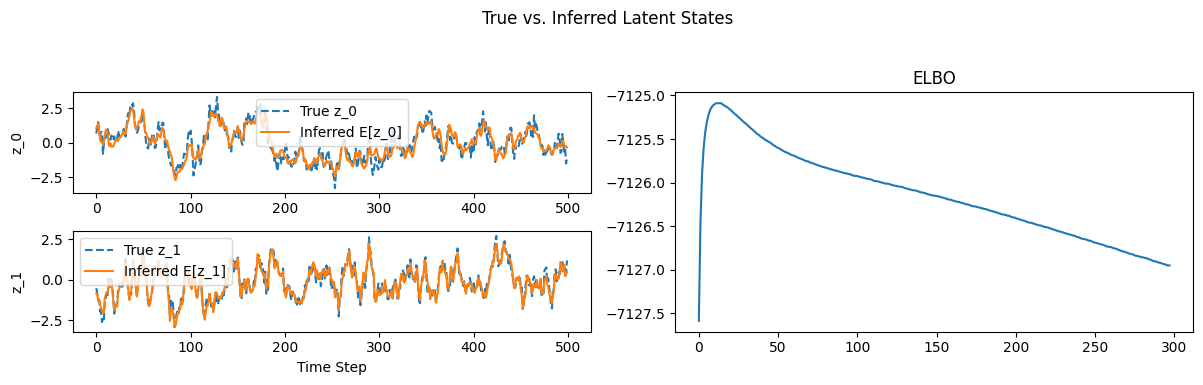

-6866.408203125


In [9]:
init_params, props = dfa_model.initialize(
    model_key,
    dynamics_weights=A_true,
    dynamics_covariance=Q_true,
    emission_weights=C_true,
    emission_covariance=R_true,
    variational_bayes=False
)

key, _key = jr.split(key)
updated_params, elbos = dfa_model.fit_em(init_params, props, y_obs, _key, num_iters=300)

# Run E-step
post = parallel_lgssm_smoother(updated_params, y_obs)
Ez_smoot = post.smoothed_means

fig = plt.figure(figsize=(12, 4))
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=1)
ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=1)
ax3 = plt.subplot2grid((2, 2), (0, 1), rowspan=2)
axes = [ax1, ax2]

ax3.plot(elbos[1:])
ax3.set_title('ELBO')

# Plot true vs inferred states (if n_components is small)
if n_components <= 3:
    if n_components == 1:
        axes = [axes] # Make iterable
    time = jnp.arange(n_timesteps)
    for i in range(n_components):
        axes[i].plot(time, z_true[:, i], label=f'True z_{i}', linestyle='--')
        axes[i].plot(time, Ez_smooth[:, i], label=f'Inferred E[z_{i}]')
        axes[i].set_ylabel(f'z_{i}')
        axes[i].legend()
    axes[-1].set_xlabel('Time Step')
    fig.suptitle('True vs. Inferred Latent States')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

print(post.marginal_loglik.item())

fig.tight_layout()

In [10]:
%timeit block_until_ready(dfa_model.fit_em(init_params, props, y_obs, _key, num_iters=100, verbose=False))
%timeit block_until_ready(eqx.filter_jit(dfa_model.fit_em)(init_params, props, y_obs, _key, num_iters=100, verbose=False))

1.17 s ± 40.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
526 ms ± 15.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


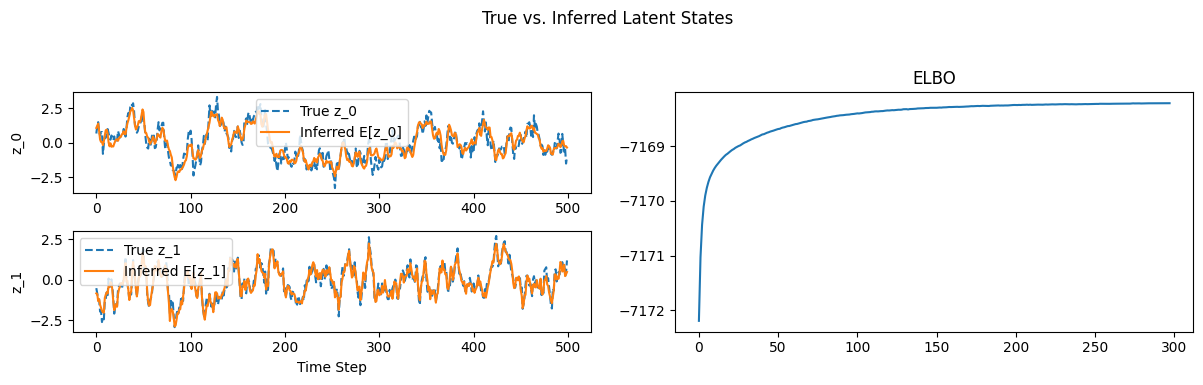

-6909.06884765625


In [11]:
init_params, props = dfa_model.initialize(
    model_key,
    dynamics_weights=A_true,
    dynamics_covariance=Q_true,
    emission_weights=C_true,
    emission_covariance=R_true,
    variational_bayes=True
)

key, _key = jr.split(key)
updated_params, elbos = dfa_model.fit_vbem(init_params, props, y_obs, _key, num_iters=300)

# Run E-step
post = sppcax_smoother(updated_params, y_obs, variational_bayes=True, parallel_scan=False)
Ez_smoot = post.smoothed_means

fig = plt.figure(figsize=(12, 4))
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=1)
ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=1)
ax3 = plt.subplot2grid((2, 2), (0, 1), rowspan=2)
axes = [ax1, ax2]

ax3.plot(elbos[1:])
ax3.set_title('ELBO')

# Plot true vs inferred states (if n_components is small)
if n_components <= 3:
    if n_components == 1:
        axes = [axes] # Make iterable
    time = jnp.arange(n_timesteps)
    for i in range(n_components):
        axes[i].plot(time, z_true[:, i], label=f'True z_{i}', linestyle='--')
        axes[i].plot(time, Ez_smooth[:, i], label=f'Inferred E[z_{i}]')
        axes[i].set_ylabel(f'z_{i}')
        axes[i].legend()
    axes[-1].set_xlabel('Time Step')
    fig.suptitle('True vs. Inferred Latent States')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

print(post.marginal_loglik.item())

fig.tight_layout()

In [12]:
%timeit block_until_ready(dfa_model.fit_vbem(init_params, props, y_obs, _key, num_iters=100, verbose=False))
%timeit block_until_ready(eqx.filter_jit(dfa_model.fit_vbem)(init_params, props, y_obs, _key, num_iters=100, verbose=False))

2.35 s ± 39.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.28 s ± 37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## 5. Test Gibbs sampling

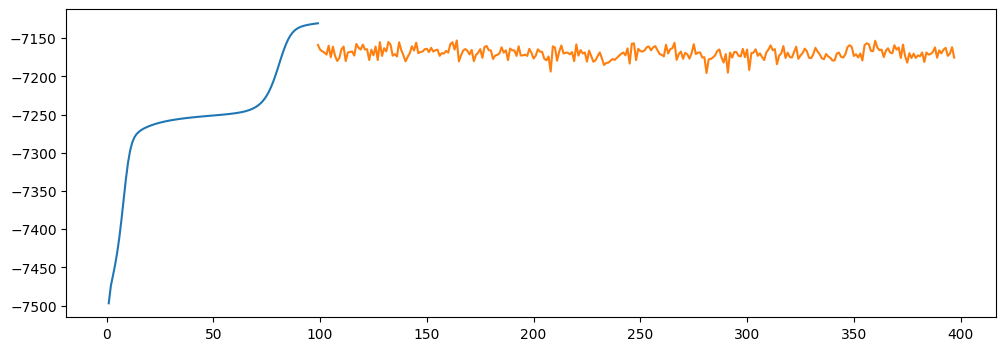

In [13]:
dfa_model = BDFA(
    n_components,
    n_features
)

key, model_key = jr.split(key)
init_params, props = dfa_model.initialize(
    model_key
)

updated_params, elbos_em = dfa_model.fit_em(init_params, props, y_obs, _key, num_iters=100)

key, _key = jr.split(key)
gibbs_params, elbos = dfa_model.fit_blocked_gibbs(
    _key, updated_params, props, sample_size=300, emissions=y_obs, verbose=True, burn_in=1)

plt.figure(figsize=(12, 4))
plt.plot(range(1, len(elbos_em) + 1), elbos_em)
plt.plot(range(len(elbos_em), len(elbos_em)+len(elbos)), elbos)

In [14]:
%timeit block_until_ready(dfa_model.fit_blocked_gibbs(_key, updated_params, props, sample_size=100, emissions=y_obs, verbose=False))

4.16 s ± 123 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
%timeit block_until_ready(eqx.filter_jit(dfa_model.fit_blocked_gibbs)(_key, updated_params, props, sample_size=100, emissions=y_obs, verbose=False))

622 ms ± 5.58 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


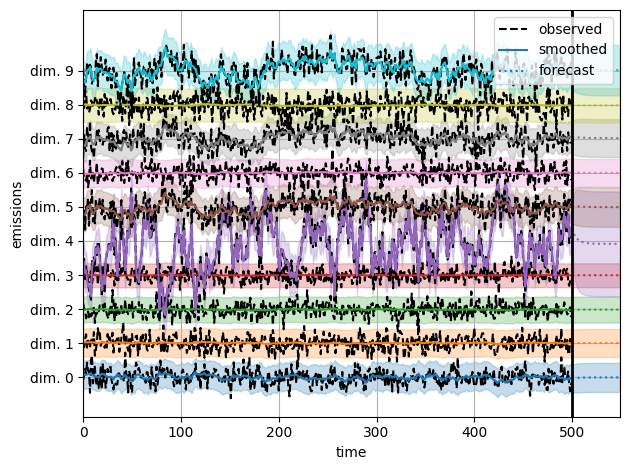

In [16]:
import matplotlib.pyplot as plt

def smooth_and_forecast(model, params, emissions, num_forecast_timesteps=50):
    smooth_emissions, smooth_emissions_std = \
        model.posterior_predictive(params, emissions)
    _, _, forecast_emissions, forecast_emissions_cov = \
        model.forecast(params, emissions, num_forecast_timesteps)
    forecast_emissions_std = jnp.sqrt(vmap(jnp.diag)(forecast_emissions_cov))
    return (smooth_emissions, 
            smooth_emissions_std, 
            forecast_emissions, 
            forecast_emissions_std)


def plot_emissions_and_forecast(emissions,
                                smooth_emissions,
                                smooth_emissions_std,
                                forecast_emissions,
                                forecast_emissions_std,
                                spc=4):
    """
    Plot the true emissions, the reconstructed emissions, and the future forecast.
    """
    num_timesteps, emission_dim = emissions.shape
    num_forecast_timesteps = forecast_emissions.shape[0]
    t_obs = jnp.arange(num_timesteps)
    t_forecast = jnp.arange(num_timesteps, num_timesteps + num_forecast_timesteps)

    for i in range(emission_dim):
        # Plot the emissions
        # axs[1].axhline(i *spc, color="black", linestyle=":", alpha=0.5)
        plt.plot(emissions[:, i] + spc * i, "--k", label="observed" if i == 0 else None)
        ln = plt.plot(t_obs, smooth_emissions[:, i] + spc * i, 
                      label="smoothed" if i == 0 else None)[0]
        plt.fill_between(
            t_obs,
            spc * i + smooth_emissions[:, i] - 2 * smooth_emissions_std[:, i],
            spc * i + smooth_emissions[:, i] + 2 * smooth_emissions_std[:, i],
            color=ln.get_color(),
            alpha=0.25,
        )
        
        # Plot the forecast
        plt.plot(t_forecast, forecast_emissions[:, i] + spc * i, 
                 ls=':', c=ln.get_color(), label="forecast" if i == 0 else None)[0]

        plt.fill_between(
            t_forecast,
            spc * i + forecast_emissions[:, i] - 2 * forecast_emissions_std[:, i],
            spc * i + forecast_emissions[:, i] + 2 * forecast_emissions_std[:, i],
            color=ln.get_color(),
            alpha=0.25,
        )

    # Draw a dividing line between observations and forecasts
    plt.axvline(num_timesteps, color="black", linestyle="-", lw=2)
        
    # Label the axes
    plt.xlabel("time")
    plt.xlim(0, num_timesteps + num_forecast_timesteps - 1)
    plt.ylabel("emissions")
    plt.yticks(spc * jnp.arange(emission_dim), 
               [f"dim. {i}" for i in jnp.arange(emission_dim)])
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

(smooth_emissions_samples, smooth_emissions_std_samples, 
 forecast_emissions_samples, forecast_emissions_std_samples) = \
    vmap(lambda params: smooth_and_forecast(dfa_model, params, y_obs))(gibbs_params)

# Compute the mean and standard deviation of the samples
burnin = 200
est_smooth_emissions = jnp.mean(smooth_emissions_samples[burnin:], axis=0)
est_forecast_emissions = jnp.mean(forecast_emissions_samples[burnin:], axis=0)
est_smooth_emissions_std = jnp.sqrt(
    jnp.mean(smooth_emissions_std_samples[burnin:] ** 2, axis=0) + 
    jnp.var(smooth_emissions_samples[burnin:], axis=0))
est_forecast_emissions_std = jnp.sqrt(
    jnp.mean(forecast_emissions_std_samples[burnin:] ** 2, axis=0) + 
    jnp.var(forecast_emissions_samples[burnin:], axis=0))

plot_emissions_and_forecast(y_obs,
                            est_smooth_emissions,
                            est_smooth_emissions_std,
                            est_forecast_emissions,
                            est_forecast_emissions_std)

# 5. Test inputs driving obs

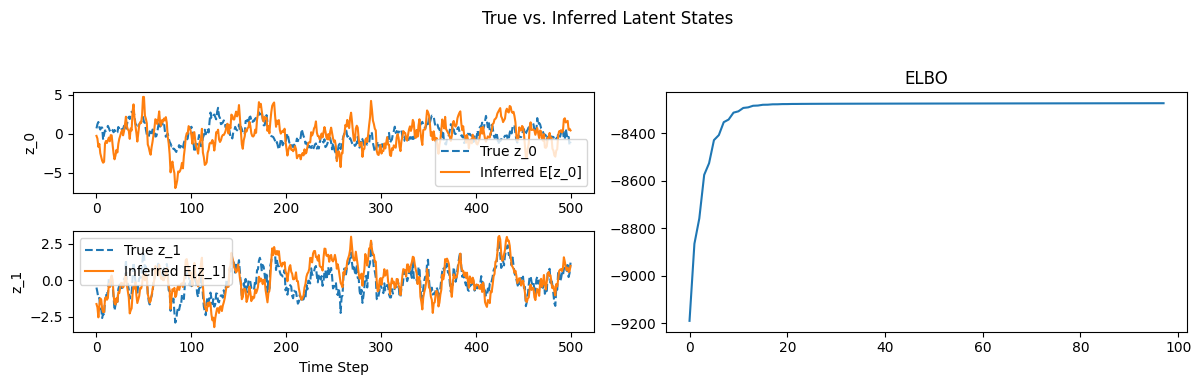

-7274.5224609375 -8273.256
0.04046379
0.29944393
0.070008755


In [17]:
from sppcax.distributions import MultivariateNormalInverseGamma as MVNIG

emission_prior = MVNIG(
    jnp.zeros((n_features, n_components + n_input + 1)),
    precision=jnp.eye(n_components + n_input + 1),
    alpha0=2.0,
    beta0=1.0,
    isotropic_noise=False,
)

dfa_model = BDFA(
    n_components,
    n_features,
    input_dim=n_input,
    emission_prior=emission_prior
)


key, model_key = jr.split(key)
init_params, props = dfa_model.initialize(
    model_key,
    variational_bayes=True
)

key, _key = jr.split(key)
updated_params, elbos_vbem = dfa_model.fit_vbem(init_params, props, y_obs_with_u, _key, U=U, num_iters=100)

# Run E-step
post = parallel_lgssm_smoother(updated_params, y_obs_with_u, inputs=U)
Ez_smooth = post.smoothed_means

fig = plt.figure(figsize=(12, 4))
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=1)
ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=1)
ax3 = plt.subplot2grid((2, 2), (0, 1), rowspan=2)
axes = [ax1, ax2]

ax3.plot(elbos_vbem[1:])
ax3.set_title('ELBO')

# Plot true vs inferred states (if n_components is small)
if n_components <= 3:
    if n_components == 1:
        axes = [axes] # Make iterable
    time = jnp.arange(n_timesteps)
    for i in range(n_components):
        axes[i].plot(time, z_true[:, i], label=f'True z_{i}', linestyle='--')
        axes[i].plot(time, Ez_smooth[:, i], label=f'Inferred E[z_{i}]')
        axes[i].set_ylabel(f'z_{i}')
        axes[i].legend()
    axes[-1].set_xlabel('Time Step')
    fig.suptitle('True vs. Inferred Latent States')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

print(post.marginal_loglik.item(), elbos_vbem[-1])


fig.tight_layout()

print(jnp.abs(updated_params.emissions.input_weights - B).mean())
print(jnp.abs(updated_params.emissions.weights - C_true).mean())
print(jnp.abs(updated_params.emissions.bias).mean())

0.05460383
0.21635129
0.2420789


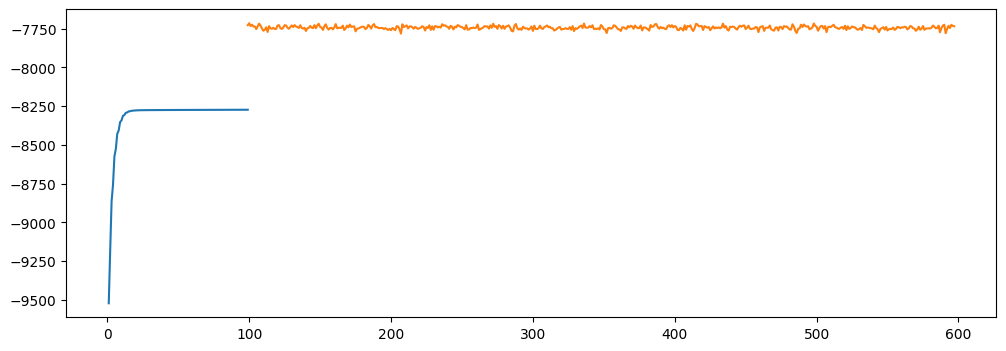

In [18]:
key, _key = jr.split(key)
gibbs_params, elbos = dfa_model.fit_blocked_gibbs(
    _key, updated_params, props, sample_size=500, emissions=y_obs_with_u, inputs=U, verbose=True, burn_in=1)

plt.figure(figsize=(12, 4))
plt.plot(range(1, len(elbos_vbem) + 1), elbos_vbem)
plt.plot(range(len(elbos_vbem), len(elbos_vbem)+len(elbos)), elbos)

print(jnp.abs(gibbs_params.emissions.input_weights - B).mean())
print(jnp.abs(gibbs_params.emissions.weights - C_true).mean())
print(jnp.abs(gibbs_params.emissions.bias).mean())

### Test Bayesian Model Reduction

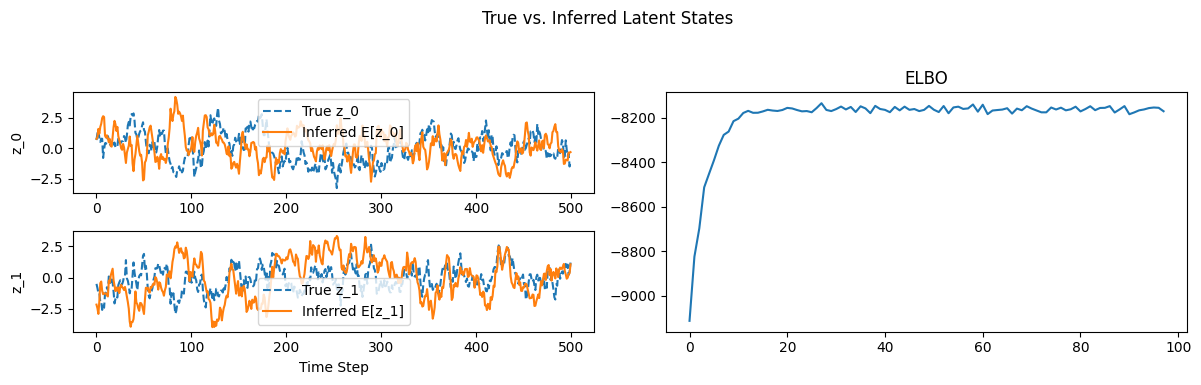

-7284.3408203125 -8171.901
0.042089902
0.43870693
0.0


In [19]:
dfa_model = BDFA(
    n_components,
    n_features,
    input_dim=n_input,
    emission_prior=emission_prior,
    use_bmr=True
)

dfa_model.use_bmr = eqx.tree_at(lambda x: x.initial, dfa_model.use_bmr, False)

key, model_key = jr.split(key)
init_params, props = dfa_model.initialize(
    model_key,
    variational_bayes=True
)

key, _key = jr.split(key)
updated_params, elbos_vbem = dfa_model.fit_vbem(init_params, props, y_obs_with_u, _key, U=U, num_iters=100)

# Run E-step
post = parallel_lgssm_smoother(updated_params, y_obs_with_u, inputs=U)
Ez_smooth = post.smoothed_means

fig = plt.figure(figsize=(12, 4))
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=1)
ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=1)
ax3 = plt.subplot2grid((2, 2), (0, 1), rowspan=2)
axes = [ax1, ax2]

ax3.plot(elbos_vbem[1:])
ax3.set_title('ELBO')

# Plot true vs inferred states (if n_components is small)
if n_components <= 3:
    if n_components == 1:
        axes = [axes] # Make iterable
    time = jnp.arange(n_timesteps)
    for i in range(n_components):
        axes[i].plot(time, z_true[:, i], label=f'True z_{i}', linestyle='--')
        axes[i].plot(time, Ez_smooth[:, i], label=f'Inferred E[z_{i}]')
        axes[i].set_ylabel(f'z_{i}')
        axes[i].legend()
    axes[-1].set_xlabel('Time Step')
    fig.suptitle('True vs. Inferred Latent States')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

print(post.marginal_loglik.item(), elbos_vbem[-1])
fig.tight_layout()

print(jnp.abs(updated_params.emissions.input_weights - B).mean())
print(jnp.abs(updated_params.emissions.weights - C_true).mean())
print(jnp.abs(updated_params.emissions.bias).mean())

0.05511868
0.41459715
0.0029675981


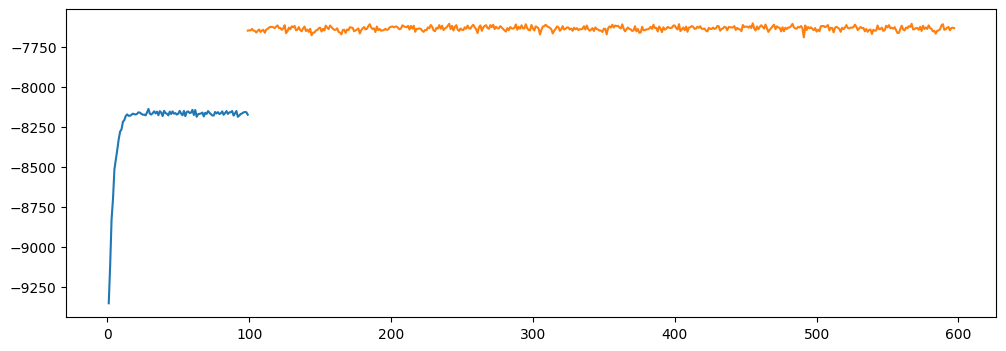

In [20]:
key, _key = jr.split(key)
gibbs_params, elbos = dfa_model.fit_blocked_gibbs(
    _key, updated_params, props, sample_size=500, emissions=y_obs_with_u, inputs=U, verbose=True, burn_in=1)

plt.figure(figsize=(12, 4))
plt.plot(range(1, len(elbos_vbem) + 1), elbos_vbem)
plt.plot(range(len(elbos_vbem), len(elbos_vbem)+len(elbos)), elbos)

print(jnp.abs(gibbs_params.emissions.input_weights - B).mean())
print(jnp.abs(gibbs_params.emissions.weights - C_true).mean())
print(jnp.abs(gibbs_params.emissions.bias).mean())

# 6. Test inputs driving factors

In [21]:
key, _key = jr.split(key)
H_true = jr.multivariate_normal(_key, jnp.zeros(n_components), Q_true, shape=(n_input)).mT
# Generate latent states (z) and observations (y)
z_true = jnp.zeros((n_timesteps, n_components))
y_obs_if = jnp.zeros((n_timesteps, n_features))

key, subkey1, subkey2 = jr.split(key, 3)
z_curr = jr.multivariate_normal(subkey1, z0_true, Sigma0_true)
z_true = z_true.at[0].set(z_curr)
y_obs_if = y_obs_if.at[0].set(jr.multivariate_normal(subkey2, C_true @ z_curr, R_true))

for t in range(1, n_timesteps):
    key, subkey1, subkey2 = jr.split(key, 3)
    z_curr = jr.multivariate_normal(subkey1, A_true @ z_curr + H_true @ U[t], Q_true)
    z_true = z_true.at[t].set(z_curr)
    y_obs_if = y_obs_if.at[t].set(jr.multivariate_normal(subkey2, C_true @ z_curr, R_true))

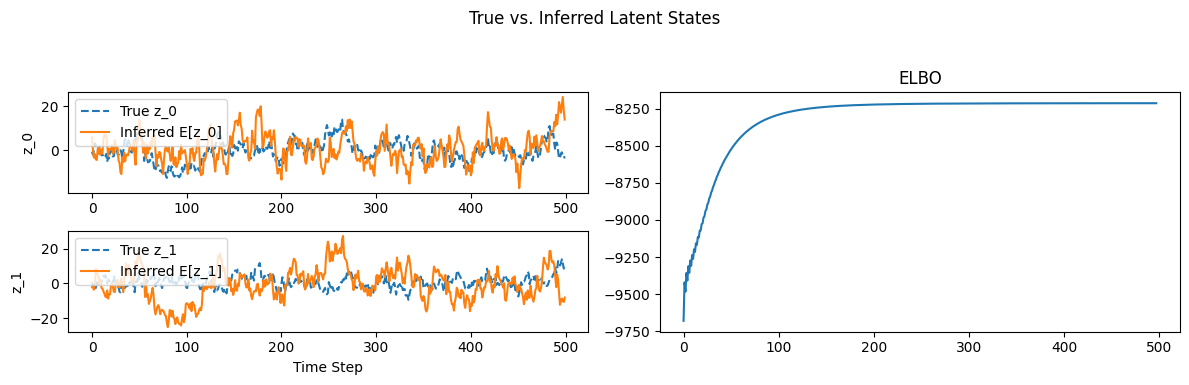

-7243.0986328125 -8213.59


In [22]:
emission_prior = MVNIG(
    jnp.zeros((n_features, n_components + n_input + 1)),
    precision=jnp.eye(n_components + n_input + 1),
    alpha0=2.0,
    beta0=1.0,
    isotropic_noise=False,
)

dynamics_prior = MVNIG(
    jnp.zeros((n_components, n_components + n_input + 1)),
    precision=jnp.eye(n_components + n_input + 1),
    alpha0=2.0,
    beta0=1.0,
    isotropic_noise=False,
)

dfa_model = BDFA(
    n_components,
    n_features,
    input_dim=n_input,
    emission_prior=emission_prior,
    dynamics_prior=dynamics_prior
)

key, model_key = jr.split(key)
init_params, props = dfa_model.initialize(
    model_key,
    variational_bayes=True
)

updated_params, elbos_vbem = dfa_model.fit_vbem(init_params, props, y_obs_if, _key, U=U, num_iters=500)

# Run E-step
post = parallel_lgssm_smoother(updated_params, y_obs_if, inputs=U)
Ez_smooth = post.smoothed_means

fig = plt.figure(figsize=(12, 4))
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=1)
ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=1)
ax3 = plt.subplot2grid((2, 2), (0, 1), rowspan=2)
axes = [ax1, ax2]

ax3.plot(elbos_vbem[1:])
ax3.set_title('ELBO')

# Plot true vs inferred states (if n_components is small)
if n_components <= 3:
    if n_components == 1:
        axes = [axes] # Make iterable
    time = jnp.arange(n_timesteps)
    for i in range(n_components):
        axes[i].plot(time, z_true[:, i], label=f'True z_{i}', linestyle='--')
        axes[i].plot(time, -Ez_smooth[:, i], label=f'Inferred E[z_{i}]')
        axes[i].set_ylabel(f'z_{i}')
        axes[i].legend()
    axes[-1].set_xlabel('Time Step')
    fig.suptitle('True vs. Inferred Latent States')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

print(post.marginal_loglik.item(), elbos_vbem[-1])
fig.tight_layout()

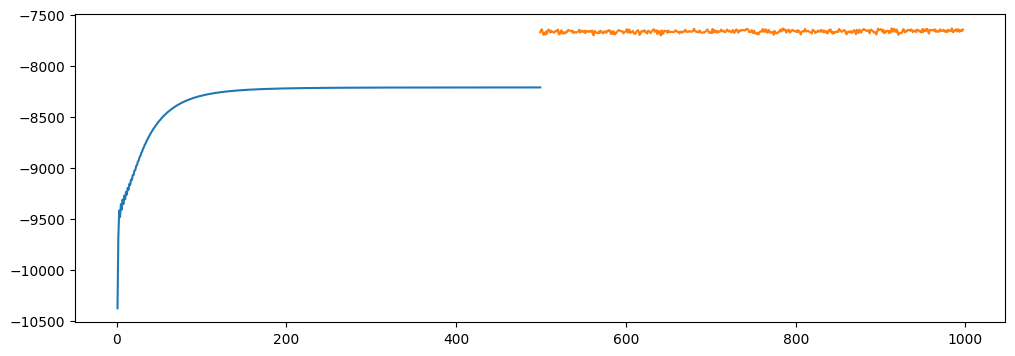

In [23]:
key, _key = jr.split(key)
gibbs_params, elbos = dfa_model.fit_blocked_gibbs(
    _key, updated_params, props, sample_size=500, emissions=y_obs_if, inputs=U, verbose=True, burn_in=1)

plt.figure(figsize=(12, 4))
plt.plot(range(1, len(elbos_vbem) + 1), elbos_vbem)
plt.plot(range(len(elbos_vbem), len(elbos_vbem)+len(elbos)), elbos)

### Test Bayesian Model Reduction

ParamsBMR(initial=False, dynamics=True, emissions=True)


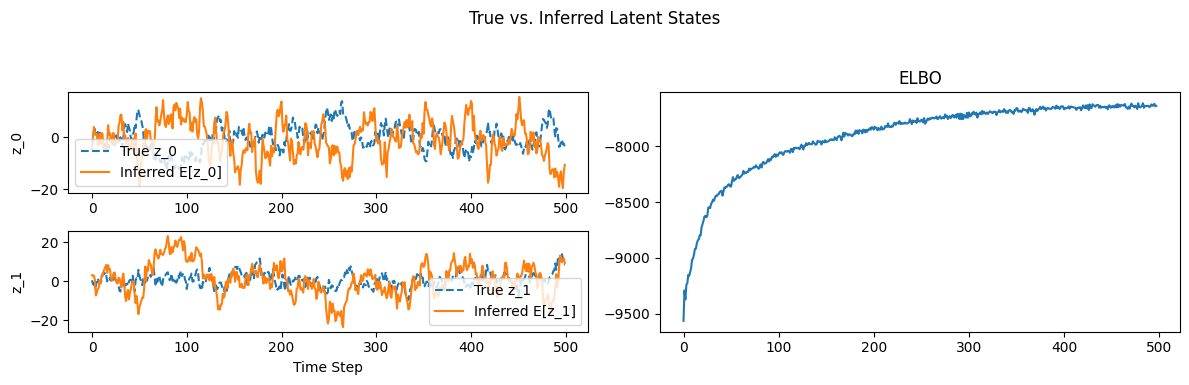

-7285.4189453125 -7640.5366


In [24]:
dfa_model = BDFA(
    n_components,
    n_features,
    input_dim=n_input,
    emission_prior=emission_prior,
    dynamics_prior=dynamics_prior
)

dfa_model.use_bmr = eqx.tree_at(lambda x: (x.emissions, x.dynamics), dfa_model.use_bmr, (True, True))
print(dfa_model.use_bmr)

key, model_key = jr.split(key)
init_params, props = dfa_model.initialize(
    model_key,
    variational_bayes=True
)

updated_params, elbos_vbem = dfa_model.fit_vbem(init_params, props, y_obs_if, _key, U=U, num_iters=500)

# Run E-step
post = parallel_lgssm_smoother(updated_params, y_obs_if, inputs=U)
Ez_smooth = post.smoothed_means

fig = plt.figure(figsize=(12, 4))
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=1)
ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=1)
ax3 = plt.subplot2grid((2, 2), (0, 1), rowspan=2)
axes = [ax1, ax2]

ax3.plot(elbos_vbem[1:])
ax3.set_title('ELBO')

# Plot true vs inferred states (if n_components is small)
if n_components <= 3:
    if n_components == 1:
        axes = [axes] # Make iterable
    time = jnp.arange(n_timesteps)
    for i in range(n_components):
        axes[i].plot(time, z_true[:, i], label=f'True z_{i}', linestyle='--')
        axes[i].plot(time, -Ez_smooth[:, i], label=f'Inferred E[z_{i}]')
        axes[i].set_ylabel(f'z_{i}')
        axes[i].legend()
    axes[-1].set_xlabel('Time Step')
    fig.suptitle('True vs. Inferred Latent States')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

print(post.marginal_loglik.item(), elbos_vbem[-1])
fig.tight_layout()

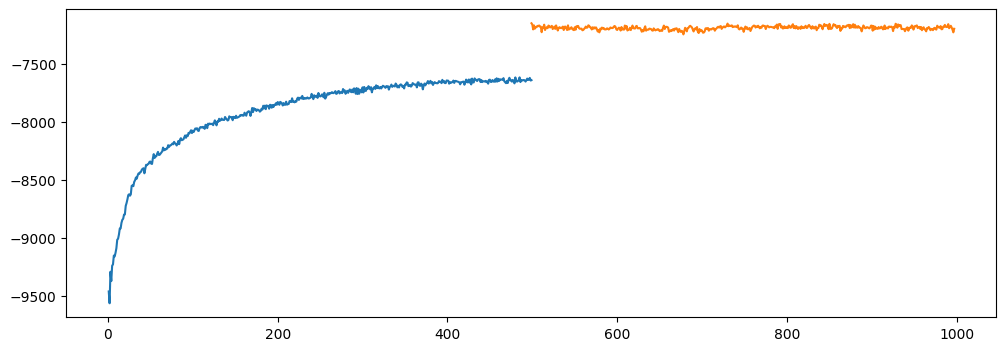

In [25]:
key, _key = jr.split(key)
gibbs_params, elbos = dfa_model.fit_blocked_gibbs(
    _key, updated_params, props, sample_size=500, emissions=y_obs_if, inputs=U, verbose=True, burn_in=1)

plt.figure(figsize=(12, 4))
plt.plot(range(1, len(elbos_vbem) + 1), elbos_vbem)
plt.plot(range(len(elbos_vbem), len(elbos_vbem)+len(elbos)), elbos)

## Controling prior structure

In [47]:
from dynamax.utils.distributions import NormalInverseWishart as NIW
from sppcax.distributions import MultivariateNormalInverseGamma as MVNIG

initial_prior = NIW(
    loc=jnp.zeros(n_components),
    mean_concentration=1.,
    df=n_components + 1.0,
    scale=jnp.eye(n_components)
)

loc = jnp.concatenate([A_true, H_true, jnp.zeros((n_components, 1))], -1)

dynamics_prior = MVNIG(
    loc,
    precision=jnp.eye(n_components + n_input + 1),
    alpha0=2.0,
    beta0=1.0,
    isotropic_noise=False,
    mask=None
)

loc = jnp.pad(C_true, [(0, 0), (0, n_input + 1)])
mask = jnp.pad(~jnp.isclose(C_true, 0.), [(0, 0), (0, n_input)], constant_values=False)
mask = jnp.pad(mask, [(0, 0), (0, 1)], constant_values=True)
emission_prior = MVNIG(
    loc,
    precision=jnp.eye(n_components + n_input + 1),
    alpha0=2.0,
    beta0=1.0,
    isotropic_noise=False,
    mask=mask
)

dfa_model = BDFA(
    n_components,
    n_features,
    input_dim=n_input,
    initial_prior=initial_prior,
    dynamics_prior=dynamics_prior,
    emission_prior=emission_prior
)

key, model_key = jr.split(key)
init_params, props = dfa_model.initialize(
    model_key,
    variational_bayes=True
)

updated_params1, elbos1 = dfa_model.fit_vbem(
    init_params, props, y_obs_if, _key, U=U, num_iters=500, verbose=False)


# Run E-step
post1 = parallel_lgssm_smoother(updated_params1, y_obs_if, inputs=U)
print(post1.marginal_loglik.item(), elbos1[-1])

loc = jnp.concatenate([A_true, H_true, jnp.zeros((n_components, 1))], -1)
mask = jnp.ones((A_true.shape[0], A_true.shape[1] + H_true.shape[1]))
mask = jnp.pad(mask, [(0, 0), (0, 1)])

dynamics_prior = MVNIG(
    loc,
    precision=jnp.eye(n_components + n_input + 1),
    alpha0=2.0,
    beta0=1.0,
    isotropic_noise=False,
    mask=mask
)

dfa_model = BDFA(
    n_components,
    n_features,
    input_dim=n_input,
    initial_prior=initial_prior,
    dynamics_prior=dynamics_prior,
    emission_prior=emission_prior
)

key, model_key = jr.split(key)
init_params, props = dfa_model.initialize(
    model_key, variational_bayes=True
)


updated_params2, elbos2 = dfa_model.fit_vbem(
    init_params, props, y_obs_if, _key, U=U, num_iters=500, verbose=False)

# Run E-step
post2 = parallel_lgssm_smoother(updated_params2, y_obs_if, inputs=U)
print(post2.marginal_loglik.item(), elbos2[-1])

dfa_model.use_bmr = eqx.tree_at(lambda x: (x.emissions, x.dynamics), dfa_model.use_bmr, (True, True))

dynamics_prior = MVNIG(
    loc,
    precision=jnp.eye(n_components + n_input + 1),
    alpha0=2.0,
    beta0=1.0,
    isotropic_noise=False,
    mask=None
)

dfa_model = BDFA(
    n_components,
    n_features,
    input_dim=n_input,
    initial_prior=initial_prior,
    dynamics_prior=dynamics_prior,
    emission_prior=emission_prior
)

key, model_key = jr.split(key)
init_params, props = dfa_model.initialize(
    model_key, variational_bayes=True
)

updated_params3, elbos3 = dfa_model.fit_vbem(
    init_params, props, y_obs_if, _key, U=U, num_iters=500, verbose=False)

# Run E-step
post3 = parallel_lgssm_smoother(updated_params3, y_obs_if, inputs=U)
print(post3.marginal_loglik.item(), elbos3[-1])

-8218.5595703125 -8384.309
-8219.046875 -8377.924
-8218.8505859375 -8379.034


(1.0, 200.0)

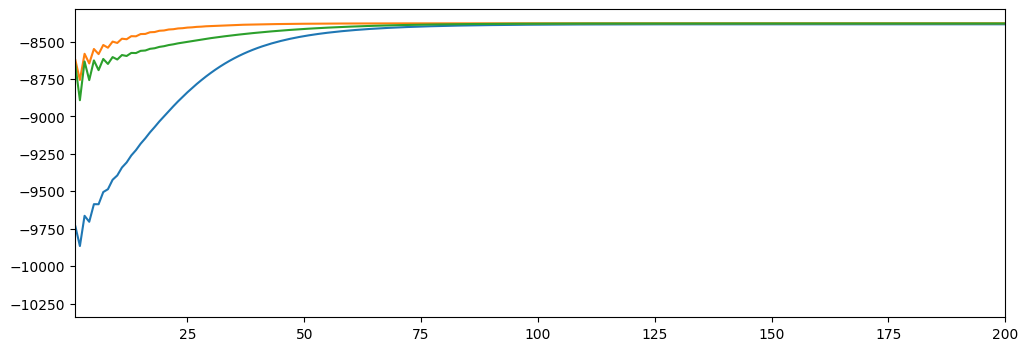

In [48]:
plt.figure(figsize=(12, 4))
plt.plot(elbos1[1:])
plt.plot(elbos2[1:])
plt.plot(elbos3[1:])
plt.xlim([1, 200])

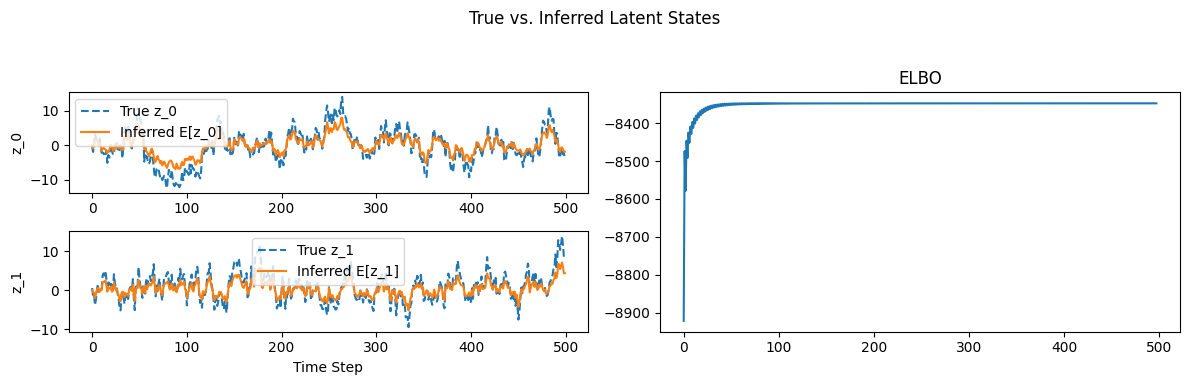

In [42]:
Ez_smooth = post3.smoothed_means
elbos = elbos3

fig = plt.figure(figsize=(12, 4))
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=1)
ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=1)
ax3 = plt.subplot2grid((2, 2), (0, 1), rowspan=2)
axes = [ax1, ax2]

ax3.plot(elbos[1:])
ax3.set_title('ELBO')

# Plot true vs inferred states (if n_components is small)
if n_components <= 3:
    if n_components == 1:
        axes = [axes] # Make iterable
    time = jnp.arange(n_timesteps)
    for i in range(n_components):
        axes[i].plot(time, z_true[:, i], label=f'True z_{i}', linestyle='--')
        axes[i].plot(time, Ez_smooth[:, i], label=f'Inferred E[z_{i}]')
        axes[i].set_ylabel(f'z_{i}')
        axes[i].legend()
    axes[-1].set_xlabel('Time Step')
    fig.suptitle('True vs. Inferred Latent States')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

fig.tight_layout()